In [1]:
# This block allows us to import from the benchmark folder,
# as if it was a package installed using pip
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

from attrbench import models, attribution, datasets

In [3]:
#ds = datasets.Cifar(batch_size=4, data_location="../data/CIFAR10", download=False, shuffle=False)
ds = datasets.ImageNette(batch_size=4, data_location="../data/imagenette2", shuffle=True)
trainloader = ds.get_dataloader(train=True)
testloader = ds.get_dataloader(train=False)

#classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = ('tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute')

In [4]:
model = models.Resnet(version="resnet18", output_logits=True, num_classes=10, params_loc="../data/models/ImageNette/resnet18.pt")
model.eval()
pass

In [5]:
def unnormalize(img):
    return (img - img.min()) / (img.max() - img.min())

def imshow(img, transpose=True):
    img = unnormalize(img)
    npimg = img.cpu().detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

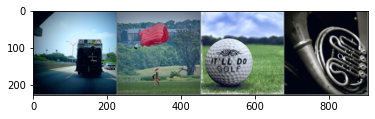

Ground Truth: garbage truck, parachute, golf ball, French horn
Predicted: garbage truck, parachute, golf ball, French horn


In [6]:
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(f"Ground Truth: {', '.join('%5s' % classes[labels[j]] for j in range(4))}")
outputs = model(images)
_, predicted = torch.max(outputs, 1)
print(f"Predicted: {', '.join('%5s' % classes[predicted[j]] for j in range(4))}")

In [7]:
ind = 3
inp = images[ind].unsqueeze(0)
inp.requires_grad = True

In [8]:
kwargs = {
    "normalize": False,
    "aggregation_fn": None
}

attribution_methods = {
    "GuidedGradCAM": attribution.GuidedGradCAM(model, model.get_last_conv_layer(), **kwargs),
    "Gradient": attribution.Gradient(model, **kwargs),
    "InputXGradient": attribution.InputXGradient(model, **kwargs),
    "IntegratedGradients": attribution.IntegratedGradients(model, **kwargs),
    "GuidedBackprop": attribution.GuidedBackprop(model, **kwargs),
    "Deconvolution": attribution.Deconvolution(model, **kwargs),
}

In [9]:
attribution_results = {}
for m_name in attribution_methods:
    model.zero_grad()
    attribution_results[m_name] = attribution_methods[m_name](inp, labels[ind])

/home/arne/Documents/PhD/projects/benchmark/venv/lib/python3.7/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:56: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


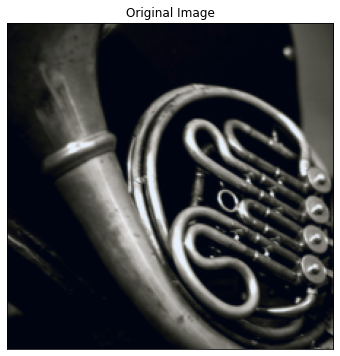

In [10]:
original_image = np.transpose(unnormalize(images[ind]).cpu().detach().numpy(), (1, 2, 0))
_ = viz.visualize_image_attr(None, original_image, method="original_image", title="Original Image")

(224, 224, 3)


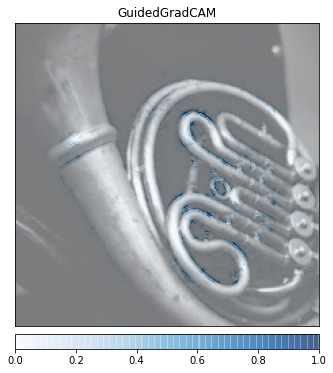

(224, 224, 3)


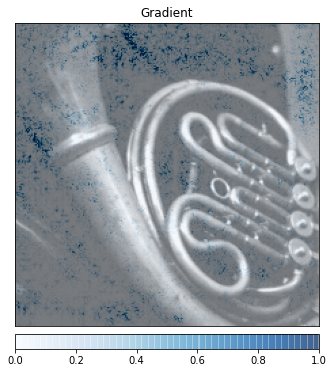

(224, 224, 3)


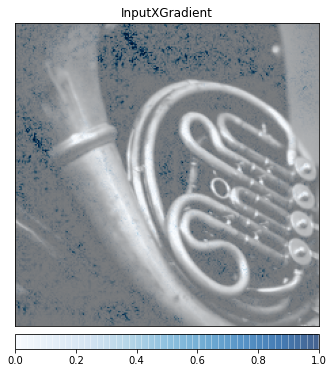

(224, 224, 3)


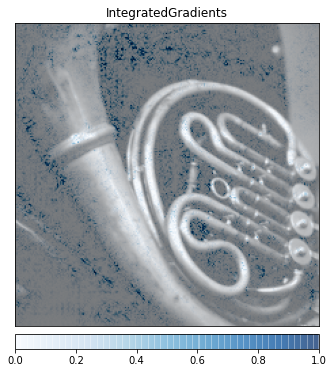

(224, 224, 3)


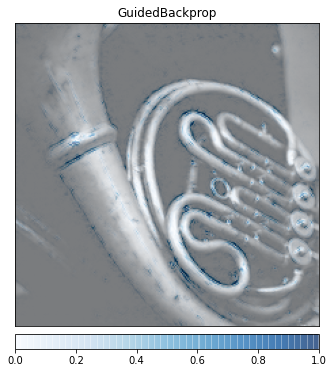

(224, 224, 3)


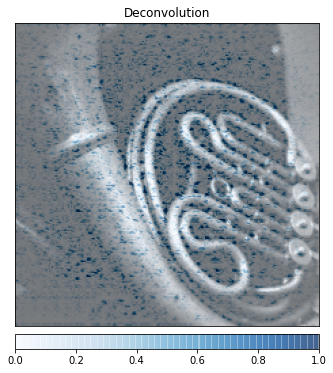

In [11]:
for m_name in attribution_results:
    attrs = attribution_results[m_name].squeeze(0).cpu().detach().numpy()
    attrs = np.transpose(attrs, (1, 2, 0))
    print(attrs.shape)
    _ = viz.visualize_image_attr(attrs, original_image, method="blended_heat_map", sign="absolute_value", show_colorbar=True, title=m_name)